In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Parallel

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.parallel import DataParallel
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size= 2048, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Initialize the model, optimizer, and criterion
model = Net().to(device)
model = DataParallel(model)  # Wrap the model with DataParallel
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 2 GPU Training

In [23]:
# Training the model
import time
num_epochs = 30
total_step = len(train_loader)
train_loss_list2 = []
train_acc_list2 = []

total_time2 = 0
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
        
    end_time = time.time()
    epoch_time = end_time - start_time
    total_time2+=epoch_time
    train_loss_list2.append(loss.item())

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        train_acc_list2.append(accuracy)

        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds\n')
        
        
print("------------------------------------------------------")
print("Total Time Taken: ",total_time2," seconds")

Accuracy: 88.09%
Time taken for epoch 1: 13.43 seconds

Accuracy: 97.31%
Time taken for epoch 2: 13.21 seconds

Accuracy: 98.59%
Time taken for epoch 3: 13.08 seconds

Accuracy: 98.83%
Time taken for epoch 4: 13.30 seconds

Accuracy: 99.06%
Time taken for epoch 5: 13.35 seconds

Accuracy: 99.02%
Time taken for epoch 6: 13.36 seconds

Accuracy: 99.14%
Time taken for epoch 7: 13.36 seconds

Accuracy: 99.10%
Time taken for epoch 8: 13.28 seconds

Accuracy: 99.18%
Time taken for epoch 9: 13.42 seconds

Accuracy: 99.29%
Time taken for epoch 10: 13.49 seconds

Accuracy: 99.27%
Time taken for epoch 11: 13.19 seconds

Accuracy: 99.31%
Time taken for epoch 12: 13.30 seconds

Accuracy: 99.30%
Time taken for epoch 13: 13.36 seconds

Accuracy: 99.29%
Time taken for epoch 14: 13.40 seconds

Accuracy: 99.43%
Time taken for epoch 21: 13.13 seconds

Accuracy: 99.49%
Time taken for epoch 22: 13.39 seconds

Accuracy: 99.35%
Time taken for epoch 23: 13.19 seconds

Accuracy: 99.36%
Time taken for epoch 24

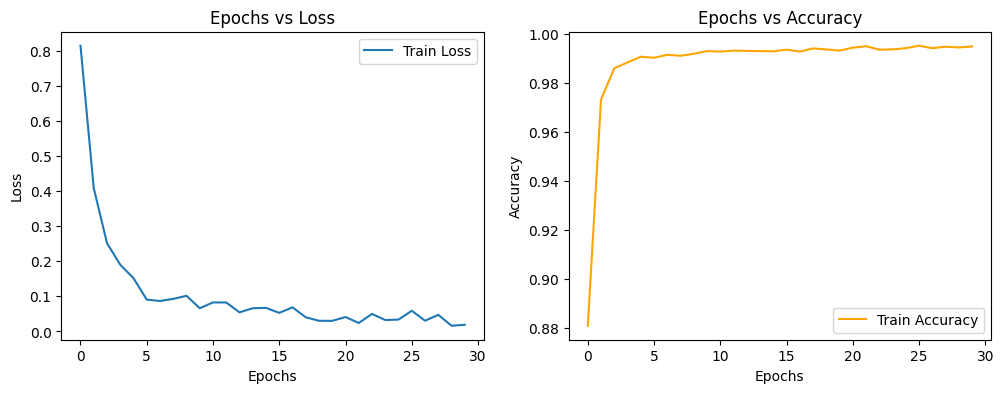

In [24]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list2, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list2, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()

plt.show()

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [26]:
# Evaluate the model
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions)

print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Axes: >

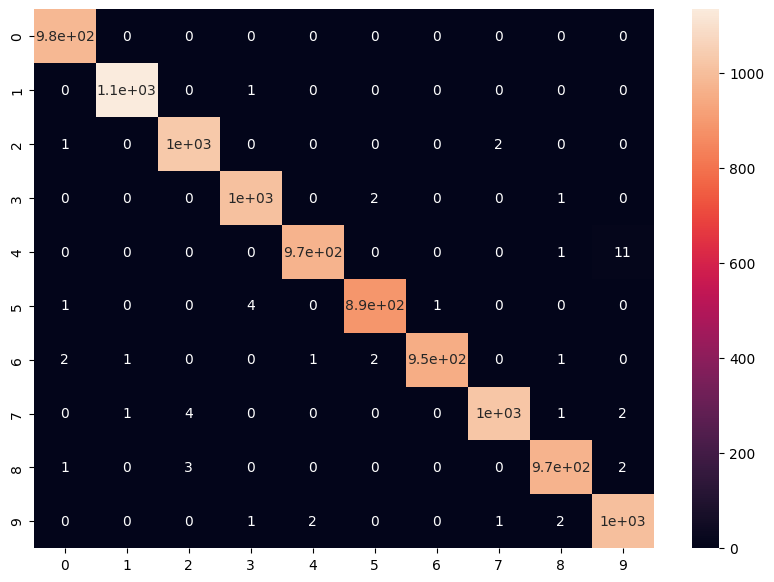

In [27]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## 1 GPU Training

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size= 2048, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Initialize the model, optimizer, and criterion
model = Net().to(device)
# model = DataParallel(model) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
import time

num_epochs = 30
total_step = len(train_loader)
train_loss_list1 = []
train_acc_list1 = []
total_time1 = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    end_time = time.time()
    epoch_time = end_time - start_time
    total_time1+=epoch_time
    train_loss_list1.append(loss.item())

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        train_acc_list1.append(accuracy)

        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds\n')
        
        
print("------------------------------------------------------")
print("Total Time Taken: ",total_time1)

Accuracy: 90.29%
Time taken for epoch 1: 12.84 seconds

Accuracy: 97.89%
Time taken for epoch 2: 13.09 seconds

Accuracy: 98.56%
Time taken for epoch 3: 12.90 seconds

Accuracy: 98.83%
Time taken for epoch 4: 13.11 seconds

Accuracy: 98.93%
Time taken for epoch 5: 13.11 seconds

Accuracy: 99.13%
Time taken for epoch 6: 12.88 seconds

Accuracy: 99.09%
Time taken for epoch 7: 13.14 seconds

Accuracy: 99.17%
Time taken for epoch 8: 13.04 seconds

Accuracy: 99.28%
Time taken for epoch 9: 12.83 seconds

Accuracy: 99.31%
Time taken for epoch 10: 12.99 seconds

Accuracy: 99.29%
Time taken for epoch 11: 12.91 seconds

Accuracy: 99.38%
Time taken for epoch 12: 12.95 seconds

Accuracy: 99.32%
Time taken for epoch 13: 13.29 seconds

Accuracy: 99.39%
Time taken for epoch 14: 12.99 seconds

Accuracy: 99.38%
Time taken for epoch 15: 13.00 seconds

Accuracy: 99.40%
Time taken for epoch 16: 13.16 seconds

Accuracy: 99.38%
Time taken for epoch 17: 13.01 seconds

Accuracy: 99.50%
Time taken for epoch 18

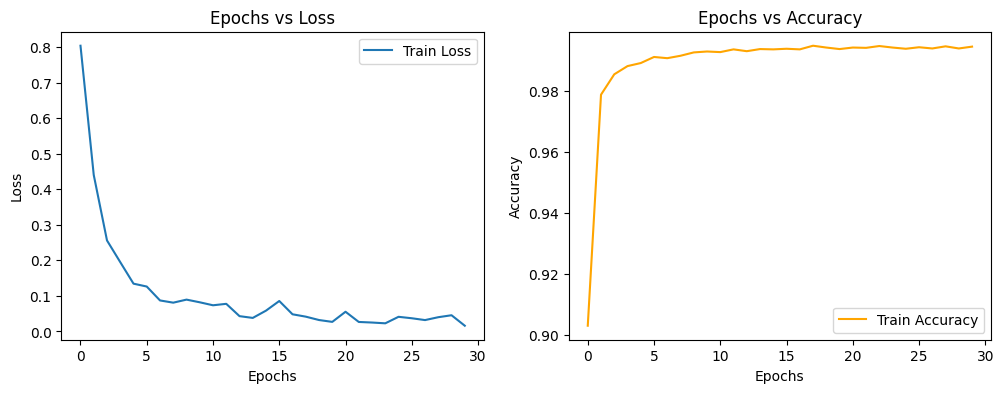

In [43]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list1, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list1, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()

plt.show()

In [44]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions)

print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Axes: >

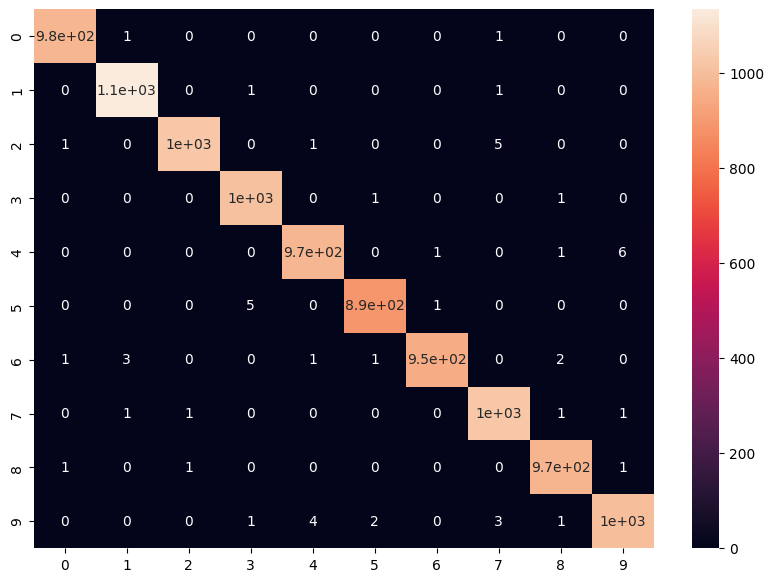

In [45]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Performance Comparison

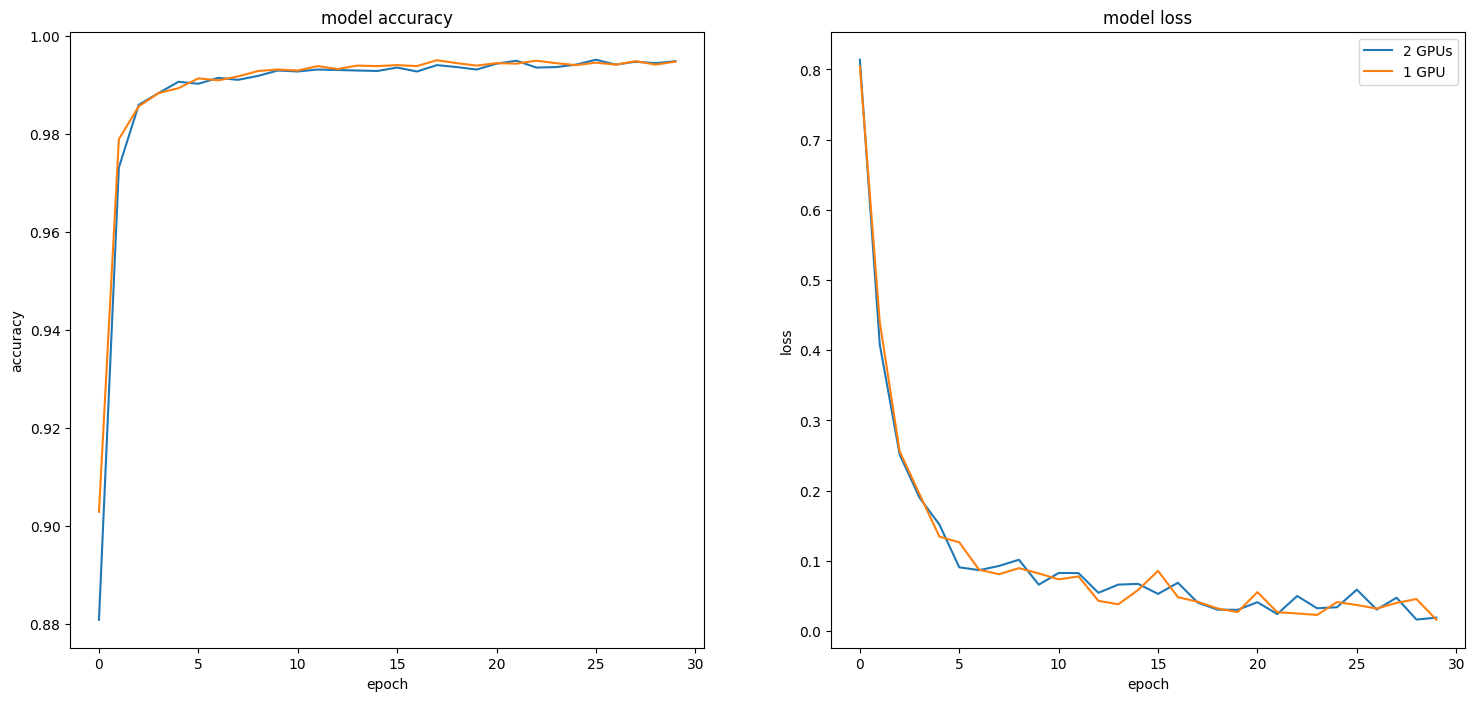

In [46]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(train_acc_list2,label = '2 GPUs')
axs[0].plot(train_acc_list1,label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(train_loss_list2,label = '2 GPUs')
axs[1].plot(train_loss_list1,label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

We achieve 48.95 percent of scaling


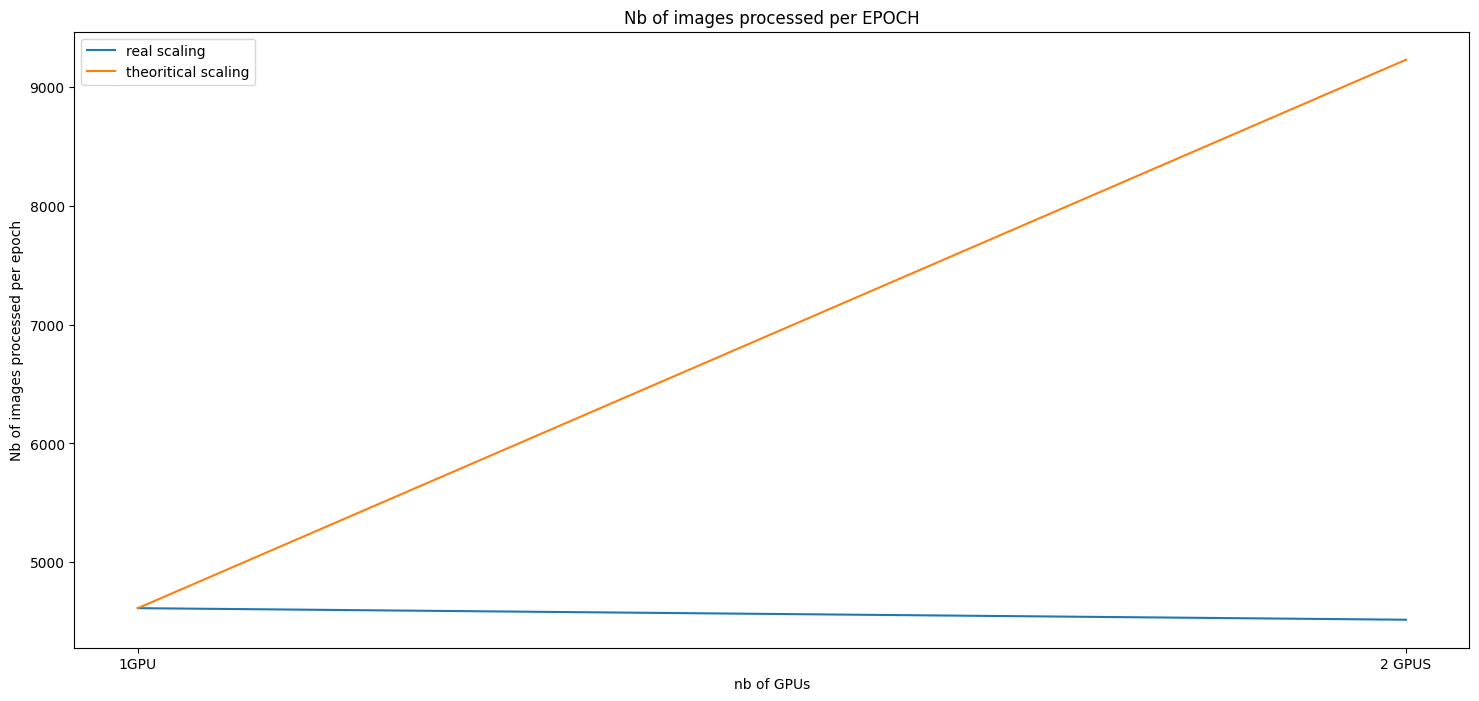

In [50]:
EPOCHS = 30
plt.figure(figsize=(18,8))
nb_images = len(train_dataset)
plt.plot(['1GPU','2 GPUS'],[nb_images/(390.10/EPOCHS),nb_images/(398.50/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(390.10/EPOCHS),2*nb_images/(390.10/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((390.10/(2*398.50))*100,2))